In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

data = pd.read_excel('EPOC dataset.xlsx')

columns = ['metal','support','wt.%','ionic species','particle size(nm)','metal loading (mg)','CO2:H2 ratio','temp(℃)','rCO(mol/s)',
          'voltage(V)','ρCO','ΛCO']
data = data[columns]

# change string in data['metal'] into int with metal's atomic mass
data['metal'] = data['metal'].replace(['Fe','Co','Ni','Cu','ZnO','Ru','Rh','Pd','Pt'],
                                      ['55.8','58.9','58.7','63.5','65.4','101.1','102.9','106.4','195.1']).astype(float)

# change string in data['wt.%'] into int, where 100: no support
data['wt.%'] = data['wt.%'].fillna(100).astype(float)


# change string in data['CO2:H2 ratio'] into int by calculating the ratios
data['gas ratio'] = data['CO2:H2 ratio'].apply(lambda x: int(x.split(':')[0]) / int(x.split(':')[1]))

# delete the data['CO2:H ratio'] column, which has been converted into data['gas ratio']
data = data.drop('CO2:H2 ratio', axis=1)

# change the columns' names into abbreviations, where M:metal, S:support, WT.%:wt.%, IS:ionic species, PS:particle size,
# ML:metal loading, T: temperature, RR:reaction rate, V:applied potential, ρ:enhancement ratio, Λ:Faradaic efficiency, GR:gas ratio
data.columns = ['M','S','WT','IS','PS','L','T','RR','V','ρ','Λ','GR']

#determine the ionic charge
ionic_charge = {
    'O2-': -2,
    'H+': 1,
    'Li+': 1,
    'Na+': 1,
    'K+': 1,
    'none': 0
}
data['IS_charge'] = data['IS'].replace(ionic_charge).fillna(0).astype(float)

# define a function to make a classification for EPOC behavior based on the applied potential and ρ values
# 0: electrophobic, 1: electrophilic
def electro_class(row):
    if row['V'] > 0 and row['ρ'] >= 1:
        return 0
    elif row['V'] < 0 and row['ρ'] >= 1:
        return 1
    elif row['V'] > 0 and row['ρ'] <= 1:
        return 1
    elif row['V'] < 0 and row['ρ'] <= 1:
        return 0
    else:
        return 'undefined'

# create a new column named 'BH' (EPOC behavior)
data['BH'] = data.apply(electro_class, axis=1)


# determine the columns that are used as features in classification
features = ['M', 'L', 'V', 'T', 'GR']

X = data[features].copy()
y = data['ρ']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [7]:
# SVM regression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

params_grid = {
    'kernel': ['rbf', 'sigmoid'],
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10, 100]
}

svr = SVR()
grid_search = GridSearchCV(estimator=svr, param_grid=params_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best parameters: ',grid_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


[0.22870205745625516, 0.2112148404553581, 0.0872396791830663, 0.455679430405983, 0.554914028900892, 0.5642872674075, 0.5808561033561326, 0.7960854140837952, 0.9212134212799049, 0.6780126026084257, 0.8648248748552427, 0.9447787464096301]
[0.3284807953193529, 0.22633060968386076, 0.03821754653056242, 0.7051638060066763, 0.726832205050048, 0.35035633715916936, 0.7453433707196255, 0.423898524226357, 0.3994722394021143, 0.7463094133608239, 0.5932978542386214, 0.09574600484620444]
[0.5918495669592039, 0.6052682489476049, 0.7003996391218266, 0.41768021879941003, 0.34153330992411335, 0.3343408271685579, 0.32162685784449213, 0.15647229522374395, 0.0604562775623388, 0.24707456250178716, 0.10372559664392379, 0.042373605868333004]
[0.5345962340267836, 0.615917965654461, 0.7656747178546026, 0.23471900411035793, 0.21746879824098886, 0.5171811218403454, 0.20273206489751255, 0.4586342091471948, 0.47807996704553485, 0.20196299864550632, 0.3237754541927712, 0.7198763297362242]


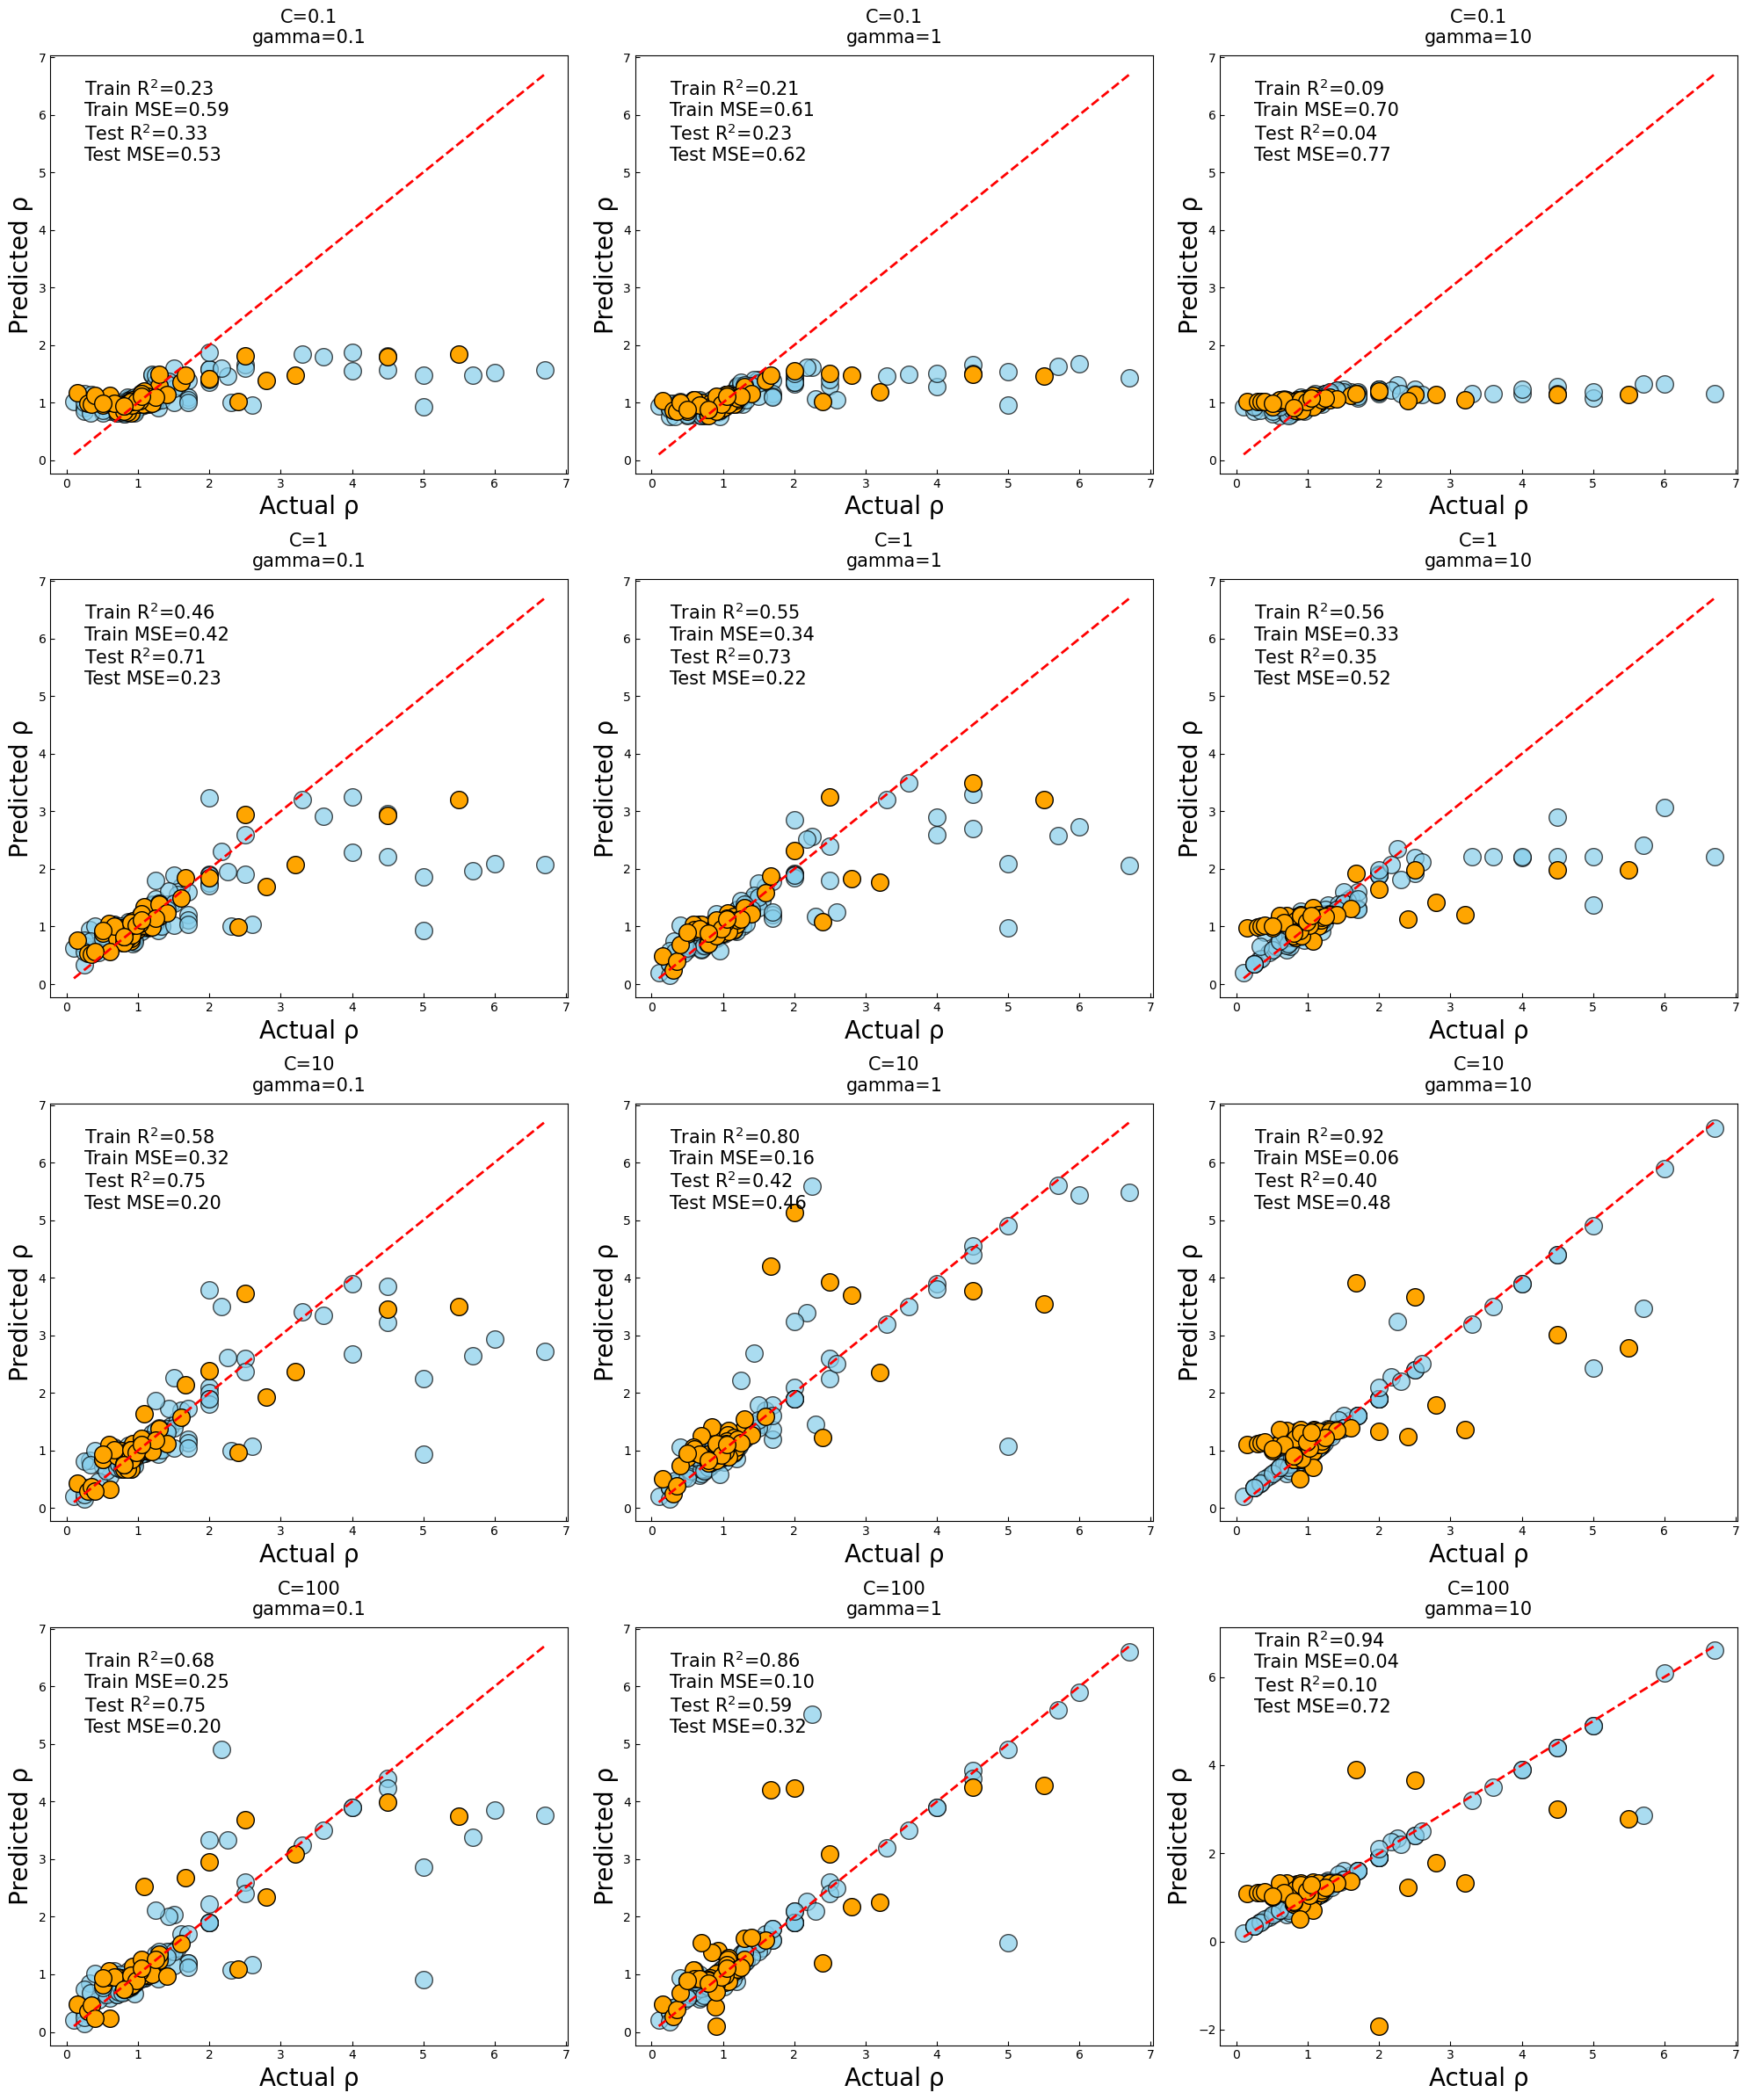

In [13]:
from sklearn.svm import SVR

n = [0.1, 1, 10]
m = [0.1, 1, 10, 100]

fig, subaxes = plt.subplots(len(m), len(n), figsize=(len(m)*5, len(n)*8))

all_train_r2 = []
all_test_r2 = []
test_mse_all=[]
train_mse_all=[]

for i, this_m in enumerate(m):
    for j, this_n in enumerate(n):
        svr = SVR(kernel='rbf', C=this_m, gamma=this_n)
        svr.fit(X_train, y_train)
        y_predict = svr.predict(X_test)
        y_predict_2 = svr.predict(X_train)

        subaxes[i, j].scatter(y_train, y_predict_2, s=200, alpha=0.7, edgecolors='black', c='skyblue')
        subaxes[i, j].scatter(y_test, y_predict, s=200, edgecolors='black', c='orange')
        subaxes[i, j].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
        subaxes[i, j].set_title(f'C={this_m}\ngamma={this_n}', pad=10, fontsize=15)
        subaxes[i, j].set_xlabel('Actual ρ', size=20)
        subaxes[i, j].set_ylabel('Predicted ρ', size=20)
        
        train_sc = svr.score(X_train, y_train)
        test_sc = svr.score(X_test, y_test)
        mse_test = mean_squared_error(y_test, y_predict)
        mse_train = mean_squared_error(y_train, y_predict_2)
        all_train_r2.append(train_sc)
        all_test_r2.append(test_sc)
        test_mse_all.append(mse_test)
        train_mse_all.append(mse_train)
        
        subaxes[i, j].text(0.25, 5.2, f'Train R$^{2}$={train_sc:.2f}\nTrain MSE={mse_train:.2f}\nTest R$^{2}$={test_sc:.2f}\nTest MSE={mse_test:.2f}',
                             fontsize=15)
        subaxes[i, j].tick_params(which='both', direction='in', labelsize=10)

print(all_train_r2)
print(all_test_r2)
print(train_mse_all)
print(test_mse_all)

plt.tight_layout()
plt.savefig('SVR prediction matrix.jpg', format='jpeg', dpi=600)
plt.show()

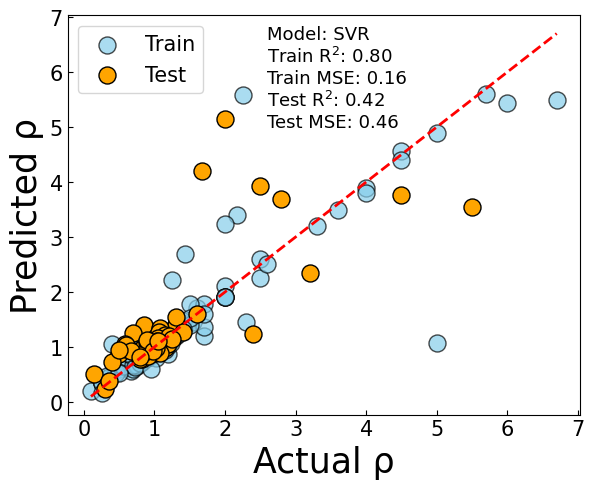

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

svr_best = SVR(kernel='rbf', C=10, gamma=1)
svr_best.fit(X_train, y_train)

y_predict = svr_best.predict(X_test)
y_predict2 = svr_best.predict(X_train)

train_score = svr_best.score(X_train, y_train)
test_score = svr_best.score(X_test, y_test)
train_mse = mean_squared_error(y_train, y_predict2)
test_mse = mean_squared_error(y_test, y_predict)

fig1 = plt.figure(figsize=(6,5))
plt.scatter(y_train, y_predict2, s=150, c='skyblue', alpha=0.7, label='Train', edgecolors='black')
plt.scatter(y_test, y_predict, s=150, c='orange', label='Test', edgecolors='black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual ρ', size=25)
plt.ylabel('Predicted ρ', size=25)
plt.text(2.6, 5, f'Model: SVR\nTrain R$^{2}$: {train_score:.2f}\nTrain MSE: {train_mse:.2f}\nTest R$^{2}$: {test_score:.2f}\nTest MSE: {test_mse:.2f}', fontsize=13)
plt.legend(loc= 2, fontsize=15, frameon=True)
plt.tick_params(which='both', direction='in', labelsize=15)
plt.tight_layout()
plt.savefig('SVR Actual vs. Predicted.jpg', format='jpeg', dpi=600)
plt.show()

Using 244 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/61 [00:00<?, ?it/s]

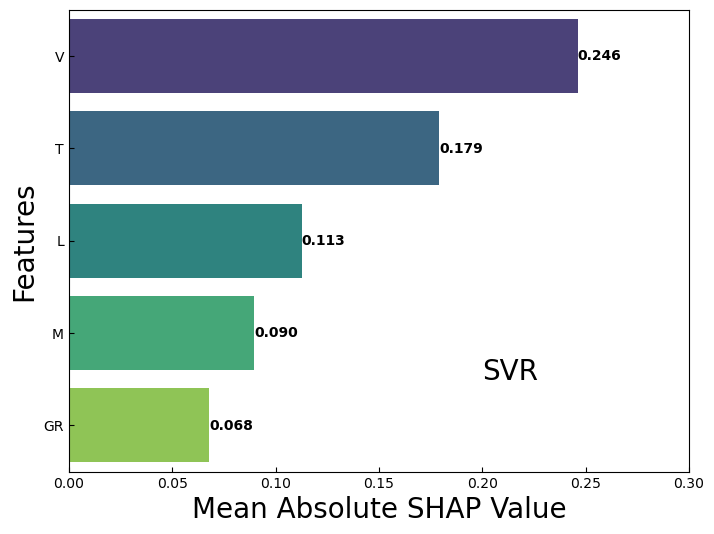

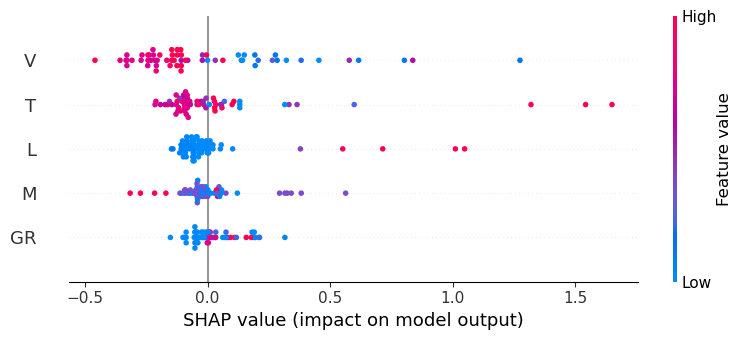

In [19]:
# use SHAP to explain and visualize the feature importance
import shap
shap.initjs()
# Creating the KernelExplainer
svr_explainer = shap.KernelExplainer(svr_best.predict, X_train)
svr_shap_values = svr_explainer.shap_values(X_test)
# Generating the bar plot with mean SHAP values and feature names
# Calculate mean absolute SHAP values for each feature
mean_abs_shap_values = np.mean(np.abs(svr_shap_values), axis=0)

# Create a DataFrame for plotting with SHAP values
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': mean_abs_shap_values})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Plotting the feature importances with values
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
# Adding the values on the bars
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', va='center', ha='left', color='black', fontweight='bold')

plt.xlim(0,0.3)
plt.xlabel('Mean Absolute SHAP Value', size=20)
plt.ylabel('Features', size=20)
plt.tick_params(which='both', direction='in', labelsize=10)
plt.text(0.2, len(importance_df) - 1.5, 'SVR', fontsize=20)
plt.savefig('SVR SHAP.jpg', format='jpeg', dpi=600)
plt.show()
# Generating the summary plot showing the distribution of SHAP values for each feature
shap.summary_plot(svr_shap_values, X_test, feature_names=X.columns)